In [1]:
import numpy as np
import os

def read_lammps_dump(filename):
    """Reads a LAMMPS trajectory file and extracts box dimensions and atomic positions."""
    with open(filename, "r") as f:
        lines = f.readlines()

    frames = []
    i = 0
    while i < len(lines):
        if "ITEM: TIMESTEP" in lines[i]:
            timestep = int(lines[i + 1].strip())
            i += 2
        elif "ITEM: BOX BOUNDS" in lines[i]:
            # Read box bounds
            x_bounds = list(map(float, lines[i + 1].strip().split()))
            y_bounds = list(map(float, lines[i + 2].strip().split()))
            z_bounds = list(map(float, lines[i + 3].strip().split()))
            i += 4
        elif "ITEM: ATOMS" in lines[i]:
            # Read atomic data
            atom_data = []
            headers = lines[i].strip().split()[2:]  # Extract column names
            i += 1
            while i < len(lines) and "ITEM:" not in lines[i]:
                atom_data.append(list(map(float, lines[i].strip().split())))
                i += 1

            atom_data = np.array(atom_data)
            frames.append({
                "timestep": timestep,
                "box": (x_bounds, y_bounds, z_bounds),
                "atoms": atom_data,
                "headers": headers,
            })
        else:
            i += 1

    return frames


def write_vasp_file(frame, filename, atom_type_map, updated_counts):
    """Writes a single frame to a VASP POSCAR/CONTCAR file."""
    x_bounds, y_bounds, z_bounds = frame["box"]
    atoms = frame["atoms"]
    headers = frame["headers"]

    # Extract lattice vectors from box bounds
    a = x_bounds[1] - x_bounds[0]
    b = y_bounds[1] - y_bounds[0]
    c = z_bounds[1] - z_bounds[0]
    lattice_vectors = np.array([
        [a, 0.0, 0.0],
        [0.0, b, 0.0],
        [0.0, 0.0, c],
    ])

    # Extract atom types and positions
    atom_types = atoms[:, headers.index("type")].astype(int)
    positions_cartesian = atoms[:, [headers.index("x"), headers.index("y"), headers.index("z")]]

    # Convert Cartesian coordinates to fractional
    inv_lattice = np.linalg.inv(lattice_vectors)
    positions_fractional = np.dot(positions_cartesian - [x_bounds[0], y_bounds[0], z_bounds[0]], inv_lattice)

    # Map numerical atom types to chemical symbols
    chemical_symbols = [atom_type_map[t] for t in atom_types]

    # Write VASP POSCAR/CONTCAR format with updated counts
    with open(filename, "w") as f:
        f.write(f"Generated from LAMMPS dump file\n")
        f.write(f"1.0\n")
        for vec in lattice_vectors:
            f.write(f"{vec[0]:.6f} {vec[1]:.6f} {vec[2]:.6f}\n")
        f.write(" ".join(updated_counts.keys()) + "\n")  # Chemical symbols
        f.write(" ".join(map(str, updated_counts.values())) + "\n")  # Updated counts
        f.write("Direct\n")
        
        for symbol in updated_counts.keys():
            count_to_write = updated_counts[symbol]
            symbol_positions = positions_fractional[np.array(chemical_symbols) == symbol]
            
            for pos in symbol_positions[:count_to_write]:
                f.write(f"{pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n")


def convert_lammps_to_vasp(dump_file, output_dir, atom_type_map, updated_counts):
    """Converts all frames of a LAMMPS dump file to VASP POSCAR/CONTCAR files."""
    frames = read_lammps_dump(dump_file)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, frame in enumerate(frames):
        filename = os.path.join(output_dir, f"CONTCAR{i+1}")
        write_vasp_file(frame, filename, atom_type_map, updated_counts)
        print(f"Saved: {filename}")


# Example usage
dump_file = "dump.nb"
output_dir = "vasp_files_900"

# Define the mapping of numerical atom types to chemical symbols
atom_type_map = {
    1: "Mg",   # Atom type 1 -> Magnesium
    2: "V",    # Atom type 2 -> Oxygen
    3: "O",    # Atom type 3 -> Vanadium
}

# Define the updated counts for each chemical symbol (e.g., O -> 60)
updated_counts = {
    "Mg": 12,
    "V": 24,
    "O": 60,
}

convert_lammps_to_vasp(dump_file, output_dir, atom_type_map, updated_counts)


Saved: vasp_files_900\CONTCAR1
Saved: vasp_files_900\CONTCAR2
Saved: vasp_files_900\CONTCAR3
Saved: vasp_files_900\CONTCAR4
Saved: vasp_files_900\CONTCAR5
Saved: vasp_files_900\CONTCAR6
Saved: vasp_files_900\CONTCAR7
Saved: vasp_files_900\CONTCAR8
Saved: vasp_files_900\CONTCAR9
Saved: vasp_files_900\CONTCAR10
Saved: vasp_files_900\CONTCAR11
Saved: vasp_files_900\CONTCAR12
Saved: vasp_files_900\CONTCAR13
Saved: vasp_files_900\CONTCAR14
Saved: vasp_files_900\CONTCAR15
Saved: vasp_files_900\CONTCAR16
Saved: vasp_files_900\CONTCAR17
Saved: vasp_files_900\CONTCAR18
Saved: vasp_files_900\CONTCAR19
Saved: vasp_files_900\CONTCAR20
Saved: vasp_files_900\CONTCAR21
Saved: vasp_files_900\CONTCAR22
Saved: vasp_files_900\CONTCAR23
Saved: vasp_files_900\CONTCAR24
Saved: vasp_files_900\CONTCAR25
Saved: vasp_files_900\CONTCAR26
Saved: vasp_files_900\CONTCAR27
Saved: vasp_files_900\CONTCAR28
Saved: vasp_files_900\CONTCAR29
Saved: vasp_files_900\CONTCAR30
Saved: vasp_files_900\CONTCAR31
Saved: vasp_files

In [2]:
import os
from ase.io import read
from pymatgen.core.structure import Structure

# Define the directory containing CONTCAR files
#vasp_dir = r"D:\docuents_trans_2_20_24\sai_mat\vijay_sir_project\md_inputs\von_1200_latest\vasp_files_50ps"
vasp_dir = r"E:\2_4_6\1000\vasp_files_900"


# List all CONTCAR files in the directory
contcar_files = [os.path.join(vasp_dir, f) for f in os.listdir(vasp_dir) if f.startswith("CONTCAR")]

# Sort files to ensure they are processed in order (e.g., CONTCAR1, CONTCAR2, ...)
contcar_files.sort()

# Convert all CONTCAR files to pymatgen Structures
structures = []
for contcar_file in contcar_files:
    # Read the VASP file using ASE
    atoms = read(contcar_file)
    
    # Extract data from ASE Atoms object
    species = atoms.get_chemical_symbols()  # Atomic species
    positions = atoms.get_positions()       # Atomic positions (Cartesian coordinates)
    lattice = atoms.get_cell()              # Lattice vectors (simulation box)
    
    # Convert to pymatgen Structure object
    structure = Structure(lattice, species, positions)
    structures.append(structure)

    print(f"Loaded structure from: {contcar_file}")

# Print summary
print(f"Number of structures loaded: {len(structures)}")


Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR1
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR10
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR100
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR1000
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR1001
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR101
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR102
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR103
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR104
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR105
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR106
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR107
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR108
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR109
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR11
Loaded structure from: E:\2_4_6\1000\vasp_files_900\CONTC

In [3]:
import os
from ase.io import read
from pymatgen.core.structure import Structure

# Define the directory containing CONTCAR files
#vasp_dir = r"D:\docuents_trans_2_20_24\sai_mat\vijay_sir_project\md_inputs\von_1200_latest\vasp_files"

# Define the output directory for filtered structures
#output_dir = r"D:\docuents_trans_2_20_24\sai_mat\vijay_sir_project\md_inputs\von_1200_latest\filtered_vasp_files_50ps"
output_dir = r"E:\2_4_6\1000\fileterd_vasp_files_1000K"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List all CONTCAR files in the directory
contcar_files = [os.path.join(vasp_dir, f) for f in os.listdir(vasp_dir) if f.startswith("CONTCAR")]

# Sort files to ensure they are processed in order (e.g., CONTCAR1, CONTCAR2, ...)
contcar_files.sort()

# Convert every 10th CONTCAR file to pymatgen Structures and save to a new folder
structures = []
for i, contcar_file in enumerate(contcar_files):
    if i % 10== 0:  # Process every 10th structure
        # Read the VASP file using ASE
        atoms = read(contcar_file)
        
        # Extract data from ASE Atoms object
        species = atoms.get_chemical_symbols()  # Atomic species
        positions = atoms.get_positions()       # Atomic positions (Cartesian coordinates)
        lattice = atoms.get_cell()              # Lattice vectors (simulation box)
        
        # Convert to pymatgen Structure object
        structure = Structure(lattice, species, positions)
        structures.append(structure)

        # Save the structure as a new CONTCAR file in the output directory
        output_file = os.path.join(output_dir, f"CONTCAR_{i+1}")
        structure.to(filename=output_file, fmt="poscar")  # Save as POSCAR/CONTCAR format
        
        print(f"Processed and saved structure from: {contcar_file} to {output_file}")

# Print summary of filtered structures
print(f"Number of structures saved: {len(structures)}")


C:\Users\DEBS\AppData\Roaming\Python\Python311\site-packages\pymatgen\io\vasp\inputs.py:660: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="wt") as file:


Processed and saved structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR1 to E:\2_4_6\1000\fileterd_vasp_files_1000K\CONTCAR_1
Processed and saved structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR106 to E:\2_4_6\1000\fileterd_vasp_files_1000K\CONTCAR_11
Processed and saved structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR115 to E:\2_4_6\1000\fileterd_vasp_files_1000K\CONTCAR_21
Processed and saved structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR124 to E:\2_4_6\1000\fileterd_vasp_files_1000K\CONTCAR_31
Processed and saved structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR133 to E:\2_4_6\1000\fileterd_vasp_files_1000K\CONTCAR_41
Processed and saved structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR142 to E:\2_4_6\1000\fileterd_vasp_files_1000K\CONTCAR_51
Processed and saved structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR151 to E:\2_4_6\1000\fileterd_vasp_files_1000K\CONTCAR_61
Processed and saved structure from: E:\2_4_6\1000\vasp_files_900\CONTCAR160 to E:\2_4_6\1000\

In [4]:
from pymatgen.analysis.diffusion.analyzer import DiffusionAnalyzer

# Perform diffusion analysis on the loaded structures
diff_analyzer = DiffusionAnalyzer.from_structures(
    structures=structures,  # Your list of pymatgen Structure objects
    specie="Mg",            # The species for which you want to analyze diffusion
    temperature=300,        # Temperature in Kelvin
    time_step=2,            # Time step between frames in femtoseconds
    step_skip=100000,         # Skip every 1000 steps for smoother analysis
    smoothed="constant",    # Smoothing method (can also be "max")
    avg_nsteps=80  # Number of steps for averaging (smaller window for finer resolution)
)

# # Print diffusivity and other properties
# print(f"Diffusivity: {diff_analyzer.diffusivity} cm^2/s")
# print(f"Mean squared displacement (MSD):\n{diff_analyzer.msd}")
# print(f"Vacancy corrected diffusivity: {diff_analyzer.vacancy_corrected_diffusivity} cm^2/s")


In [5]:

#diff_calc.plot_msd(mode='default')
diff_analyzer.export_msdt("md_50ps")
import os
import pandas as pd
msd_md = pd.read_table("md_50ps", delimiter=' ')
print(msd_md)

          #            t         MSD       MSD_a       MSD_b        MSD_c  \
0         0     0.000000    0.000000    0.000000    0.000000     0.000000   
1    200000    78.567527   19.227579   27.199943   32.140005    93.608516   
2    400000   133.951126   32.475682   47.996184   53.479260   160.401783   
3    600000   186.646945   44.234098   68.372082   74.040765   224.041572   
4    800000   242.668653   56.240130   89.227718   97.200805   290.722872   
5   1000000   300.376848   69.574625  110.543417  120.258806   365.615335   
6   1200000   362.997635   81.423878  134.691092  146.882665   448.821908   
7   1400000   428.291594   94.030408  158.384873  175.876313   508.849203   
8   1600000   500.886291  107.702747  185.082284  208.101260   586.381942   
9   1800000   567.584013  117.498307  211.816428  238.269277   663.273025   
10  2000000   637.649519  129.116996  240.924616  267.607907   759.525182   
11  2200000   712.438397  141.231208  271.015679  300.191510   866.444249   

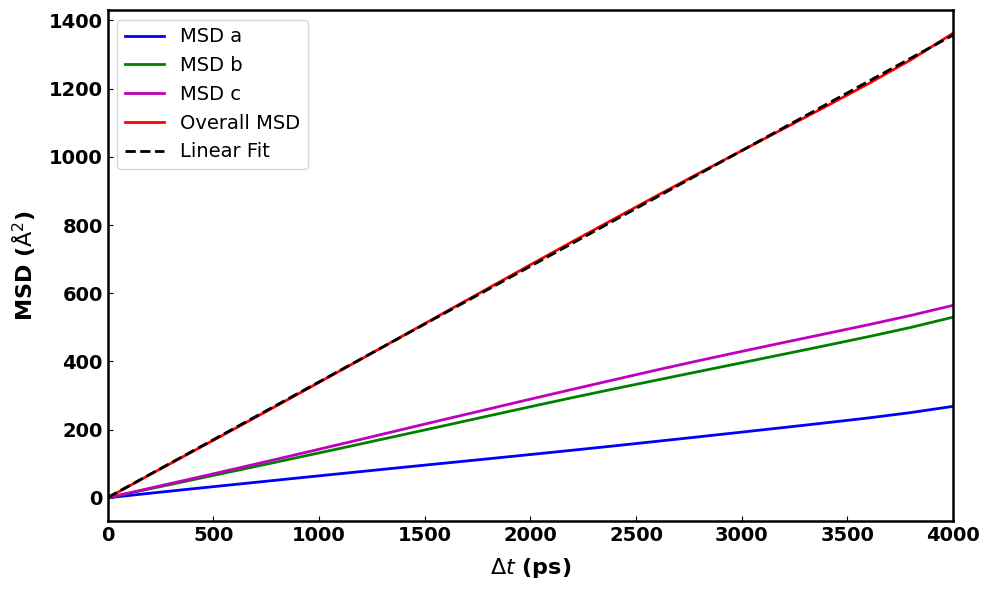

Diffusion Coefficient (Å^2/ps): 0.056512
Diffusion Coefficient (cm^2/s): 5.651171e-06


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming msd_md is already loaded as a DataFrame
time_fs = msd_md['#']
time = time_fs / 1000  # Convert time to ps

# MSD series
msd_a = msd_md['MSD']
msd_b = msd_md['MSD_a']
msd_c = msd_md['MSD_b']
msd_t = msd_md['t']

# Define delta_t values (in ps)
delta_t_steps = np.arange(0, 4200, 200)  # Delta t: 200, 400, ..., 4000

# Initialize lists for storing results
delta_t_values = [0]  # Start with the origin point (0, 0)
MSD_a_averages = [0]  # Start with MSD = 0 at delta_t = 0
MSD_b_averages = [0]
MSD_c_averages = [0]
MSD_t_averages = [0]

# Calculate MSD for each delta_t
for delta_t in delta_t_steps:
    msd_a_values = []  # To store MSD for each interval in msd_a
    msd_b_values = []  # To store MSD for each interval in msd_b
    msd_c_values = []  # To store MSD for each interval in msd_c
    msd_t_values = []  # To store MSD for each interval in msd_t

    # Loop through valid time windows based on delta_t
    for start_idx in range(len(msd_a) - delta_t // 200):  # 200 ps corresponds to a step size of 1 in your data
        end_idx = start_idx + delta_t // 200  # Calculate the index for delta_t

        # Ensure the indices are valid
        if end_idx < len(msd_a):
            # Calculate MSD for each series
            msd_a_values.append(msd_a.iloc[end_idx] - msd_a.iloc[start_idx])
            msd_b_values.append(msd_b.iloc[end_idx] - msd_b.iloc[start_idx])
            msd_c_values.append(msd_c.iloc[end_idx] - msd_c.iloc[start_idx])
            msd_t_values.append(msd_t.iloc[end_idx] - msd_t.iloc[start_idx])

    # Calculate the average MSD for this delta_t if valid values are found
    if msd_a_values:
        MSD_a_averages.append(np.mean(msd_a_values))
        MSD_b_averages.append(np.mean(msd_b_values))
        MSD_c_averages.append(np.mean(msd_c_values))
        MSD_t_averages.append(np.mean(msd_t_values))
        delta_t_values.append(delta_t)

# Plot MSD vs Delta t
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the MSD data with continuous lines (no markers)
ax.plot(delta_t_values, MSD_a_averages, '-', label='MSD a', linewidth=2, color='b')
ax.plot(delta_t_values, MSD_b_averages, '-', label='MSD b', linewidth=2, color='g')
ax.plot(delta_t_values, MSD_c_averages, '-', label='MSD c', linewidth=2, color='m')
ax.plot(delta_t_values, MSD_t_averages, '-', label='Overall MSD', linewidth=2, color='r')

# Add a linear regression line for the overall MSD
slope, intercept, r_value, p_value, std_err = linregress(delta_t_values, MSD_t_averages)
r_squared = r_value**2
ax.plot(delta_t_values, intercept + slope * np.array(delta_t_values), '--', label=f'Linear Fit', color='black', linewidth=2)

# Axis labels and legend
ax.set_xlabel(r'$\Delta t$ (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
ax.legend(loc="upper left", fontsize=14)

# Adjust axis line widths
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.8)

# Set ticks and styles
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')
plt.xlim(0, 4000)
# Show the plot
plt.tight_layout()

# Save the figure as PDF
plt.savefig("msd_vs_delta_t_all_series_300_continuous.pdf", format='pdf')
plt.savefig("msd_vs_delta_t_all_series_300_continuous.tif", format='tif')

# Display the plot
plt.show()

# Print the calculated diffusivity
print(f"Diffusion Coefficient (Å^2/ps): {slope / 6:.6f}")
print(f"Diffusion Coefficient (cm^2/s): {slope / 6 * 1e-4:.6e}")


In [7]:
import pandas as pd

# Create a DataFrame with Delta t and Overall MSD
df = pd.DataFrame({
    'Delta_t (ps)': delta_t_values,
    'Overall MSD (Å²)': MSD_t_averages
})

# Save to Excel
df.to_excel("1000_msd_246_4000ps.xlsx", index=False)

print("Data saved to 1000_msd_4000ps.xlsx successfully!")


Data saved to 1000_msd_4000ps.xlsx successfully!


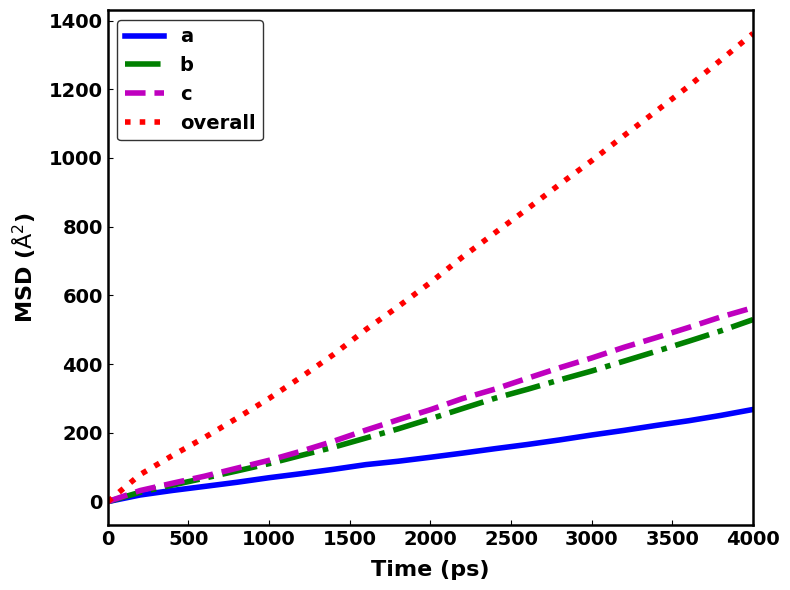

Diffusion Coefficient (Å^2/ps): 0.056655
Diffusion Coefficient (cm^2/s): 5.665471e-06
R^2 Score: 0.9983


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming msd_md is already loaded as a DataFrame
time_fs = msd_md['#']
time = time_fs / 1000  # Convert time to ps

# Extract MSD components
msd_a = msd_md['MSD']
msd_b = msd_md['MSD_a']
msd_c = msd_md['MSD_b']
msd_t = msd_md['t']

# Filter the data to include only up to 40,000 ps
max_time_ps = 40000
valid_indices = time <= max_time_ps
time_filtered = time[valid_indices].to_numpy()  # Convert to NumPy array
msd_a_filtered = msd_a[valid_indices].to_numpy()
msd_b_filtered = msd_b[valid_indices].to_numpy()
msd_c_filtered = msd_c[valid_indices].to_numpy()
msd_t_filtered = msd_t[valid_indices].to_numpy()

# Calculate diffusivity using linear regression
slope, intercept, r_value, _, _ = stats.linregress(time_filtered, msd_t_filtered)
diff_coeff_ang = slope / 6  # Diffusion coefficient in Å^2/ps
diff_coeff_cm = diff_coeff_ang * 1e-4  # Convert to cm^2/s
r_squared = r_value**2

# Plotting
legend_properties = {'weight': 'bold', 'size': 14}
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(time_filtered, msd_a_filtered, linewidth=4, linestyle='-', color='b', label='a')
ax.plot(time_filtered, msd_b_filtered, linewidth=4, linestyle='dashdot', color='g', label='b')
ax.plot(time_filtered, msd_c_filtered, linewidth=4, linestyle='--', color='m', label='c')
ax.plot(time_filtered, msd_t_filtered, linewidth=4, linestyle='dotted', color='r', label='overall')

# No linear fit plot

# Set x-axis limit
plt.xlim(0, 4000)

# Axis labels and legend
ax.set_xlabel('Time (ps)', fontsize=16, fontweight='bold', labelpad=8)
ax.set_ylabel('MSD ($\mathrm{\AA^2}$)', fontsize=16, fontweight='bold', labelpad=8)
ax.legend(prop=legend_properties, loc="upper left", edgecolor='k')

# Adjust axis line widths
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.8)

# Set ticks and styles
plt.xticks(weight='bold', fontsize=14)
plt.yticks(weight='bold', fontsize=14)
plt.tick_params(direction='in')

# Save the figure
plt.tight_layout()
plt.savefig("nonlinear_tif_1000_246.tif", dpi=300, format='tiff', bbox_inches='tight')
plt.show()

# Print results
print(f"Diffusion Coefficient (Å^2/ps): {diff_coeff_ang:.6f}")
print(f"Diffusion Coefficient (cm^2/s): {diff_coeff_cm:.6e}")
print(f"R^2 Score: {r_squared:.4f}")
